# Understanding subunit selectivity in a deep network#

The units in a convolutional neural network have three fundamental dimensions to their weights: rows, columns, and channels. We call the set of weights across input channels at a particular row and column to be a spatial subunit. We have looked at how selectivity of subunits relates to each other but not at subunit selectivity itself. We have learned many interesttng things about this spatial structure which have provided promising predictions in the nervous system about how responses to stimuli at different spatial positions should relate to physiology. Some of these prediction have already gathered promising preliminary evidence. But we would now like to understand what individual subunits are actually doing not just how they relate to each other.

The basic tactic we will take is to hypothesize some property of the weights as important to the response properties of that subunit, then examine how that property of the weights varies across units and layers, then investigate what exactly is it functional consequence. Below I make a couple observations about some properties of the weights but we do not have a firm sense of the functional consequence of these patterns.

To start of we will look at the mean to variance ratio of the weights for a subunit. Since all inputs to units are positive and responses at each layer are rectified we know that all negative weights drive a unit away from responding. So for example a unit with all negative weights would never respond to any input. This would be the case if the mean was a very large negative number and the variance was very low we can say this unit would be very sparse in its responses. On the other hand a subunit unit would give a response to any input if its weights mean was a very large negative number and its variance was low thus this unit would have low sparsity.. 

But first how to load some data:

## Loading data ##

In [3]:
# below I will just show you how to load up filter weight data and and response data
#to analyze this data you will need python, jupyter notebook, xarray, numpy
#an easy way to do this is to install conda then on the terminal 
#call conda install for each package.
from scipy.stats import kurtosis

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import xarray as xr

#here we load up all the sample data sets of responses
load_resp_dir = '/Users/wangyuening/Documents/Data_AlexNet/' #you will need to change this to where ever you put the files
load_wts_dir = '/Users/wangyuening/Documents/Data_AlexNet/' #you will need to change this to where ever you put the files

layer_resp = {}
layer_wts = {}
layer_names = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5']
for layer_name in layer_names:
    layer_resp[layer_name] = xr.open_dataset(load_resp_dir + layer_name + '_0.nc')['resp']
    layer_wts[layer_name] = xr.open_dataset(load_wts_dir + layer_name + '_filts.nc')['filts']

#lets take a look at just the first layer
conv1resp = layer_resp['conv1']
conv1wts = layer_wts['conv1']

ims = xr.open_dataset(load_resp_dir + 'data_0.nc')['resp']

In [4]:
#see that the filter weights for the first layer have 96 units, 3 channels, and are 11 by 11
print(conv1wts)

<xarray.DataArray 'filts' (unit: 96, channel: 3, r: 11, c: 11)>
array([[[[-0.001214, ..., -0.020662],
         ...,
         [-0.000825, ..., -0.009904]],

        ...,

        [[-0.014439, ..., -0.021937],
         ...,
         [-0.003733, ...,  0.024118]]],


       ...,


       [[[ 0.007968, ..., -0.041835],
         ...,
         [ 0.007691, ..., -0.020299]],

        ...,

        [[ 0.001863, ..., -0.0612  ],
         ...,
         [ 0.00404 , ..., -0.020825]]]], dtype=float32)
Coordinates:
  * unit     (unit) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * r        (r) int32 0 1 2 3 4 5 6 7 8 9 10
  * c        (c) int32 0 1 2 3 4 5 6 7 8 9 10
  * channel  (channel) int32 0 1 2


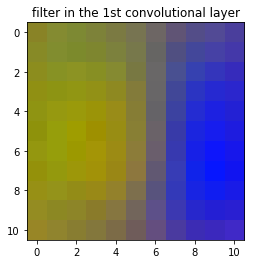

In [5]:
#lets take a look at one of the units 
filt_num = 77
#here we just transpose and normalize filter weights to look at them
filt = conv1wts.isel(unit=filt_num).transpose('r','c','channel');
filt = filt - filt.min();
filt = filt/filt.max();
plt.imshow(filt);plt.title('filter in the 1st convolutional layer');
#clearly this filter is looking for a yellow blue edge

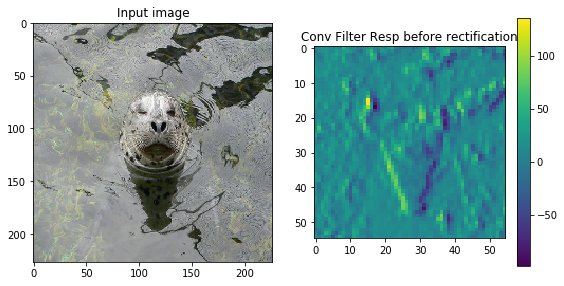

In [6]:
#now lets look at what the response of this filter looks like across an input image
im = 32
plt.figure(figsize=(8,4))
plt.subplot(122)
resp = conv1resp.isel(im=im, unit=filt_num).transpose('r','c');
plt.imshow(resp.values);plt.title('Conv Filter Resp before rectification')
plt.colorbar();
plt.subplot(121)
the_input_im = ims.isel(im=im).transpose('r','c','unit')
the_input_im = the_input_im - the_input_im.min()
the_input_im = the_input_im/the_input_im.max()
plt.imshow(the_input_im[..., ::-1]);plt.title('Input image');
plt.tight_layout();
#clearly it is detecting edges across this picture of a seal notice
#that the output is smaller in pixels then the input because the filter is strided
#i.e. shifts 4 pixels.

## Mean variance ratio of subunit weights##

/Users/wangyuening/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/wangyuening/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/wangyuening/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/wangyuening/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


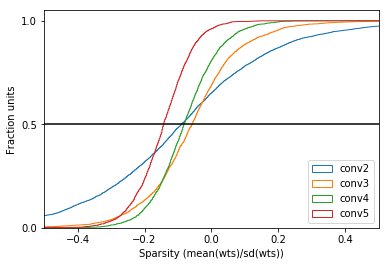

In [7]:
mv_ratio = {}
for layer in layer_names[1:]:
    a_wts = layer_wts[layer]
    m = (a_wts.mean('channel'))
    v = (a_wts).std('channel')
    mv_ratio[layer]= m/v
    #plt.figure()
    plt.hist(m.values.ravel()/v.values.ravel(), histtype='step', bins=1000, range=[-1,1], cumulative=True,normed=True);
plt.xlabel('Sparsity (mean(wts)/sd(wts))');plt.ylabel('Fraction units');
plt.xlim(-.5,.5);
plt.legend(layer_names[1:], loc='lower right');
plt.plot([-100,1000], [0.5,0.5], color='k')
plt.yticks([0,.5,1]);

Generally what we see for the convolutional layers is a mainly an increase in sparsity in Conv5, along with a decrease in the variety of sparsity. 

Deeper in the network we tend to be more inhibitory but also we have less variability in whether we will tend to have occasionally really inhbitory vs really excitatory. It will be interesting to see this for deeper layers. This could either relate to spatial arguments about non-overlapping subunits splitting into inhibitory and excitatory patches.
When you have a channel with a high positive mean and low sd, this means that any feature coming in contributes to a greater response. When you have a channel with a negative mean and low sd you reject everything coming in. When you have a high SD and low mean it means you are balanced in the channel, taking in as much as you reject. On average we tend to have a negative mean, that has a quarter of the magnitude of the sd thus we mostly reject.

A mystery that remains is functionally what it means to have mostly inhibitory weights or low variance. One path to gaining insight is to visualizes these subunits preferences from both ends of the distribution and see if you can determine what distinguishes them.

Further work analysis of weights can look at whether within units this selectivity is more similar then across units.

/Users/wangyuening/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


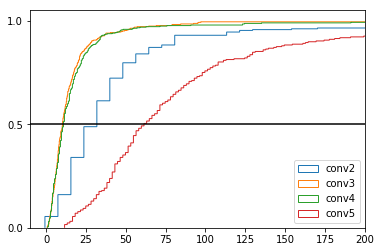

In [8]:
for layer in layer_names[1:]:
    resp = layer_resp[layer].transpose('unit', 'im', 'r', 'c').values
    resp = resp.reshape((resp.shape[0],)+(np.product(resp.shape[1:]),))
    resp[resp<0] = 0
    k = kurtosis(resp, 1).ravel()
    plt.hist(k, histtype='step', bins=1000, cumulative=True,normed=True);
plt.legend(layer_names[1:], loc='lower right')
plt.xlim(-10,200)
plt.plot([-100,1000], [0.5,0.5], color='k')
plt.yticks([0,.5,1]);

Similarly to above in the actual kurtosis (sparseness) of the rectified responses, we see conv3 and conv4 are similar. Conv2 has higher kurtosis though on avere it has about the same mean to variance ratio in the subunit weights as conv3 and conv4. While conv5 as we would expect is the most kurtotic 
    

## Subunit weights as a function of weight covariance of inputs ##

Another way to interpret subunits weights is with respect to the selectivity of their inputs. We then have to come up with some measure of the properties of their inputs then see if the weights on these inputs varies systematically as a function of that measure. 

Here we will look at the property of weight covariance of the inputs. Weight covariance tells us essentially whether the input unit is looking for a surface or a transition. Formally it calculates the covariance between the weights of all subunits, sums it up, then normalizes by the most that sum could have been. For a value of 1 it means subunits all had identical weights and for zero it means they were orthogonal.

One thing that I noticed in your visualizations is when a unit was selective for an object often it would have positve weights on a variety of boundaries (e.g. transitions from light to dark and also dark to light) presumably so that the unit would respond to many possible boundaries with different surfaces but the same 'shape'. 

One hypothesis is that to be selective for a particular object with a surface and boundaries the subunits representing boundaries will tend to be less selective because they need to respond to many different possible boundaries whereas the subunits selective for a surface can afford more selectivity. So I would predict subunit weights will tend to more often be positive on inputs with low weight covariance and more often negative on inputs with high weight covariance.

Lets check this below:


In [9]:
#below is a function to calculate weight covariance
def weight_cov(da):
    da = da.transpose('unit', 'channel', 'r', 'c')
    data = da.values.reshape(da.shape[:2] + (np.product(da.shape[2:]),))#unravel to unitX channelX (r*c) then get raw values
    cov = np.matmul(data.transpose(0, 2, 1), data)#get the cov matrix
    cov = cov.sum(axis=(1,2)) - np.trace(cov, axis1=1, axis2=2)# sum up the cov matrix, but subtract off the diagonal
    
    vnorm = np.linalg.norm(data, axis=1)#get the length of each subunits weights
    #get the product of all lengths with all lengths, this is the largest their covariance could be
    outer_prod = (vnorm[:, :, np.newaxis])*(vnorm[:, np.newaxis, :])

    outer_prod = outer_prod.sum(axis=(1,2)) - np.trace(outer_prod, axis1=1, axis2=2)#sum up products subtracting off diag
    wc = cov / outer_prod#divde covariance by how big it could have been at most
    
    wc_da = xr.DataArray(wc, dims=('unit',))#put back into xarrya
    wc_da.coords['unit'] = da.coords['unit']#get back unit indexing
    
    return wc_da

#put weight covariance into dictionary
conv_wc = {}
for layer in layer_names:
    conv_wc[layer] = weight_cov(layer_wts[layer])

/Users/wangyuening/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/wangyuening/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/wangyuening/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/wangyuening/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


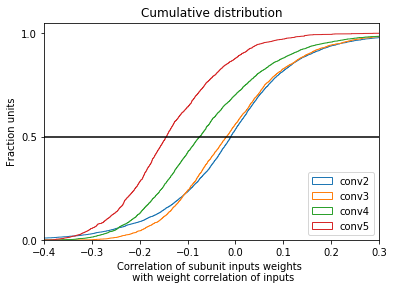

In [10]:
#function for correlating weight covariance in previous layer with subunit weights in next
def correlate(wc, wt):
    #subtract off mean and normalize wc
    wc = wc-wc.mean('unit')
    wc = wc/(wc**2).sum('unit')**0.5
    #rename the unit dimension to channel so that input units match to input channels in higher layer
    wc = wc.rename({'unit':'channel'})
    
    #subtract off mean and normalize wts
    wt = wt-wt.mean('channel')
    wt = wt/(wt**2).sum('channel')**0.5
    
    #get product of wc and wts across all subunits (using broadcasting)
    #then sum across channels to get r then unravel
    r = (wc.values.reshape(1,wc.shape[0],1,1)*wt.values).sum(1).ravel()
    return r

#go through layer and layer + 1 through all layers 
for layer0, layer1 in zip(layer_names, layer_names[1:]):
    cwc0 = conv_wc[layer0]
    cwt1 = layer_wts[layer1]
    
    #if the number of input units is not equal to channels then there is grouping
    if cwc0.shape[0]==cwt1.shape[1]:
        r = correlate(cwc0, cwt1)
    #if there is grouping this means the units in layer+1 only take inputs from half of the units in the previous layer
    #precisely the first half of units in the previous layer are inputs to the first half of units in the next layer
    # and second half to second half
    else:
        #so we get these seperate;y
        r1 = list(correlate(cwc0[:len(cwc0)//2], cwt1[:len(cwt1)//2]))
        r2 = list(correlate(cwc0[len(cwc0)//2:], cwt1[len(cwt1)//2:]))
        r = r1 + r2
    plt.hist(r, histtype='step', bins=1000,  cumulative=True, normed=True);
    plt.xlim(-0.4, 0.3)
plt.legend(layer_names[1:], loc='lower right');plt.yticks([0,.5,1]);plt.plot([-1,1], [0.5,0.5], color='k')
plt.title('Cumulative distribution');
plt.ylabel('Fraction units');plt.xlabel('Correlation of subunit inputs weights \n with weight correlation of inputs');


We again see a progression as a function of depth in the means of this correlation. Early layers tend to have the same number of units with negative weights on low weight covariance inputs as positive weights on low weight covariance inputs. But the hypothesis does seem to hold up for  conv4 and conv5 which tend to have a negative correlation between weights and weight covariance, thus positive weights tend to be on low weight covariance inputs and negative weights on high weight covariance units. 

Again the mystery here is exactly what the functional consequence of this is, how it plays out in units. Visualizing subunits across space at the extreme ends of these distributions could be very helpful.

In addition there are potentially more weight analyses to perform.

In [11]:
def rand_index(da):
    import random
    index = random.sample(range(len(da)),len(da))
    return index


In [12]:
rand_index([3,4,5])

[1, 0, 2]

In [13]:
reindex_layer_wts = {}
for layer in layer_names:
    index = rand_index(layer_wts[layer])
    print(len(index))
    arr = xr.concat([layer_wts[layer][i] for i in index],dim='unit')
    reindex_layer_wts[layer] = arr

96
256
384
384
256


In [14]:
print(reindex_layer_wts['conv1'][0][0])
print(layer_wts['conv1'][0][0])

<xarray.DataArray 'filts' (r: 11, c: 11)>
array([[-0.041185, -0.042754, -0.046813, -0.046818, -0.043354, -0.04039 ,
        -0.042099, -0.043146, -0.040264, -0.038268, -0.032388],
       [-0.042643, -0.046736, -0.051921, -0.0521  , -0.044037, -0.037306,
        -0.039161, -0.035033, -0.033858, -0.035037, -0.030339],
       [-0.041267, -0.040911, -0.05479 , -0.049634, -0.039731, -0.030539,
        -0.025888, -0.023353, -0.025016, -0.027757, -0.02318 ],
       [-0.041224, -0.039159, -0.047842, -0.044392, -0.032975, -0.020541,
        -0.004714,  0.001037, -0.005784, -0.009563, -0.00832 ],
       [-0.032081, -0.035242, -0.039694, -0.036345, -0.016643,  0.005376,
         0.022174,  0.029203,  0.032993,  0.015537,  0.008156],
       [-0.023584, -0.027906, -0.033572, -0.01847 ,  0.001273,  0.027254,
         0.047451,  0.061865,  0.060035,  0.034936,  0.021171],
       [-0.02164 , -0.024373, -0.027591, -0.008991,  0.017993,  0.049121,
         0.078918,  0.083865,  0.078296,  0.058686,  0.0

In [15]:
reindex_conv_wc = {}
for layer in layer_names:
    reindex_conv_wc[layer] = weight_cov(reindex_layer_wts[layer])

/Users/wangyuening/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/wangyuening/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/wangyuening/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/wangyuening/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


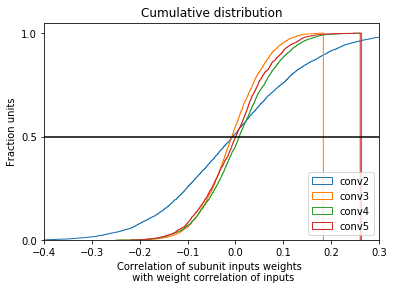

In [16]:
for layer0, layer1 in zip(layer_names, layer_names[1:]):
    cwc0 = reindex_conv_wc[layer0]
    cwt1 = layer_wts[layer1]
    
    #if the number of input units is not equal to channels then there is grouping
    if cwc0.shape[0]==cwt1.shape[1]:
        r = correlate(cwc0, cwt1)
    #if there is grouping this means the units in layer+1 only take inputs from half of the units in the previous layer
    #precisely the first half of units in the previous layer are inputs to the first half of units in the next layer
    # and second half to second half
    else:
        #so we get these seperate;y
        r1 = list(correlate(cwc0[:len(cwc0)//2], cwt1[:len(cwt1)//2]))
        r2 = list(correlate(cwc0[len(cwc0)//2:], cwt1[len(cwt1)//2:]))
        r = r1 + r2
    plt.hist(r, histtype='step', bins=1000,  cumulative=True, normed=True);
    plt.xlim(-0.4, 0.3)
plt.legend(layer_names[1:], loc='lower right');plt.yticks([0,.5,1]);plt.plot([-1,1], [0.5,0.5], color='k')
plt.title('Cumulative distribution');
plt.ylabel('Fraction units');plt.xlabel('Correlation of subunit inputs weights \n with weight correlation of inputs');



#  <span style="color:blue">Conclusion:</span>
* The shape of the plot is little different from the one before randomizing the index
* The negative correlation is less obvious
* one possible cause would be randomizing part messes the data.<span style="color:brown">please help me check the codes above...First time deal with xarray datastructure</span>)
* The other cause would be that negative correlation is related to the relation between weight covariance of previous layer and the weights on those units.

#  <span style="color:blue">Question and plans:</span>
* I will play with the subunits on the extreme ends, I think I need to:
    * Set a value to define 'extreme'
    * Visualize the reponse and compare to weight covarianve and weights. Try to find pattern
* My question is:
    * What we are exactly to use as observations?(Still those pictures or feature maps. Or are there other parameters?)
    
## Please help me check my understanding and comprise the future plan. Thank you very much